In [3]:
import torchvision
import torch

In [5]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [33]:
from torchvision.datasets import CIFAR10
from torchvision.models import efficientnet_b1
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


In [9]:
mean=[0.49139968, 0.48215827 ,0.44653124]
std=[0.24703233, 0.24348505, 0.26158768]

In [10]:
cifar_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [39]:
batch_size = 32

trainset = CIFAR10(root='./data', train=True, download=True, transform=cifar_transforms)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transforms)
val_size = len(testset) // 2
test_size = len(testset) - val_size
valset, testset = torch.utils.data.random_split(testset, [val_size, test_size])
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
model = efficientnet_b1()

In [ ]:
epochs = 45
optimizer = AdamW(params=model.parameters(), lr=0.001, weight_decay=0.0025)
scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-5)

loss_fn = CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def training_step(model, trainloader):
  model.train()
  total_loss=0
  total_labels=0
  correct=0
  for data_instance in trainloader:
    inputs, labels = data_instance
    inputs = inputs.to(device)
    labels = labels.to(device)
    total_labels+=len(labels)
    optimizer.zero_grad()
    outputs = model(inputs)
    _, predicted=torch.max(outputs, 1)
    correct+=(predicted==labels).sum().item()
    loss = loss_fn(outputs, labels)
    total_loss+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"epoch: {epoch+1}: Training Loss: {total_loss/len(trainloader)}, accuracy: {correct/total_labels}")


def validation_step(model, valloader):
  model.eval()
  with torch.no_grad():
    total_loss = 0
    total_labels=0
    correct=0
    for data_instance in valloader:
      inputs, labels=data_instance
      inputs = inputs.to(device)
      labels = labels.to(device)
      total_labels+=len(labels)
      outputs = model(inputs)
      _, predicted=torch.max(outputs, 1)
      correct+=(predicted==labels).sum().item()
      loss = loss_fn(outputs, labels)
      total_loss+=loss.item()
    print(f"Validation Loss: {total_loss/len(valloader)}, accuracy: {correct/total_labels}")


In [ ]:
for epoch in range(epochs):
  training_step(model, trainloader)
  validation_step(model, valloader)
  scheduler.step()

Training Loss: 1.5801901429491172, accuracy: 0.43328
Validation Loss: 1.1125229726171797, accuracy: 0.6078
Training Loss: 1.0052225959278114, accuracy: 0.64544
Validation Loss: 0.8228696943468349, accuracy: 0.7164
Training Loss: 0.7483186772997686, accuracy: 0.7437
Validation Loss: 0.6611772158722968, accuracy: 0.7676
Training Loss: 0.6007817539452591, accuracy: 0.79662
Validation Loss: 0.5515947493777913, accuracy: 0.8104
Training Loss: 0.5059816830494202, accuracy: 0.82786
Validation Loss: 0.4726470919551363, accuracy: 0.8424
Training Loss: 0.43296924308752754, accuracy: 0.85282
Validation Loss: 0.4652679091805865, accuracy: 0.848
Training Loss: 0.3772100462594325, accuracy: 0.87088
Validation Loss: 0.4377657538101931, accuracy: 0.8576
Training Loss: 0.3234202259494872, accuracy: 0.88858
Validation Loss: 0.42381074061249474, accuracy: 0.8604
Training Loss: 0.2831043098062296, accuracy: 0.90166
Validation Loss: 0.3731810386013833, accuracy: 0.8752
Training Loss: 0.23996973055237886, a

In [ ]:
dummy_input = dummy_input = torch.randn(1, 3, 224, 224)
dummy_input = dummy_input.to(device)
model.eval()
torch.onnx.export(
    model,
    dummy_input,
    "image_classification_model.onnx",
    input_names=["image"],   # you name your input here
    output_names=["predicted_class"], # you name your output here
    dynamic_axes={
        "image": {0: "batch_size"},            # input batch dimension is dynamic
        "predicted_class": {0: "batch_size"},  # output batch dimension is dynamic
    },
    opset_version=17,
    do_constant_folding=True
)

print("model converted to onnx")

/tmp/ipython-input-2703609823.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


model converted to onnx


In [ ]:
from google.colab import files
files.download("image_classification_model.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
ort_session = ort.InferenceSession("image_classification_model.onnx")

In [21]:
labels_list = []
prediction_list = []
for data in testloader:
  images, labels = data
  images = images.cpu().numpy().astype(np.float32)
  labels = labels.cpu().numpy()
  labels_list.extend(labels)
  output =np.argmax(ort_session.run(None, {"image": images})[0], axis=1)
  prediction_list.extend(output)

labels_list = np.array(labels_list)
prediction_list = np.array(prediction_list)

In [27]:
precision_per_class = precision_score(y_true = labels_list, y_pred=prediction_list, average=None)
for index in range(len(classes)):
  print(f"{classes[index]}: {precision_per_class[index]}")

plane: 0.9341085271317829
car: 0.943359375
bird: 0.9081419624217119
cat: 0.8535469107551488
deer: 0.920388349514563
dog: 0.8366606170598911
frog: 0.9261477045908184
horse: 0.945031712473573
ship: 0.9450980392156862
truck: 0.9486166007905138


In [29]:
recall_per_class = recall_score(y_true = labels_list, y_pred=prediction_list, average=None)
for index in range(len(classes)):
  print(f"{classes[index]}: {recall_per_class[index]}")

plane: 0.9305019305019305
car: 0.9679358717434869
bird: 0.8787878787878788
cat: 0.7987152034261242
deer: 0.915057915057915
dog: 0.8865384615384615
frog: 0.9527720739219713
horse: 0.93125
ship: 0.9469548133595285
truck: 0.9467455621301775


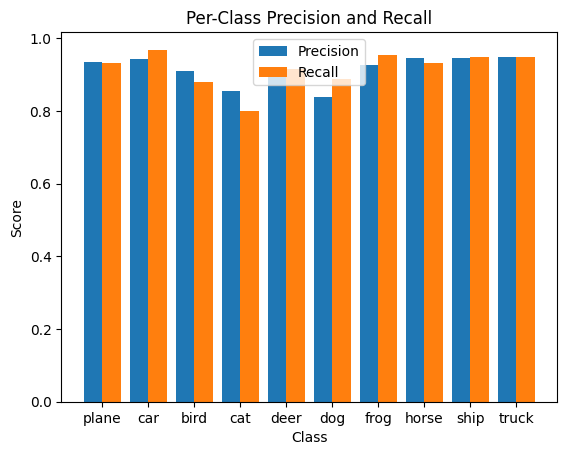

In [46]:
x = np.arange(len(classes))

plt.bar(x - 0.2, precision_per_class, width=0.4, label='Precision')
plt.bar(x + 0.2, recall_per_class, width=0.4, label='Recall')

plt.xticks(x, classes)
plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Per-Class Precision and Recall")
plt.legend()
plt.show()

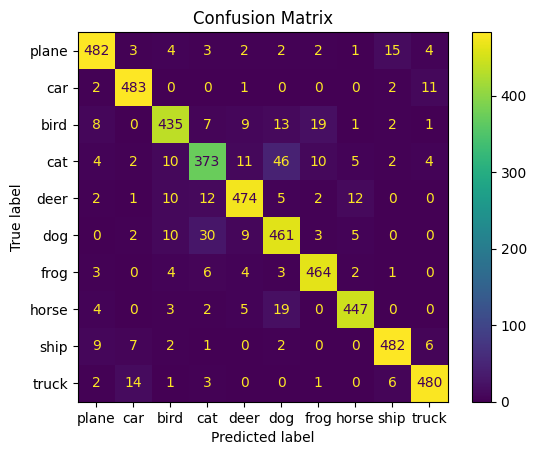

In [47]:
conf_matrix = confusion_matrix(y_true = labels_list, y_pred=prediction_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot()
plt.title("Confusion Matrix")
plt.show()